# Classification problem on the Titanic data set

## First some imports

In [745]:
import numpy as np
import pandas as pd
import re

# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# For missing numbers (just for convenience)
import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

# All models used here
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

## Read in the data

In [611]:
df_train = pd.read_csv("../data/train.csv")
df_test  = pd.read_csv("../data/test.csv")

df_train.drop(columns=["PassengerId"], inplace=True)
PassengerId = df_test["PassengerId"]
df_test.drop(columns=["PassengerId"], inplace=True)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [612]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [613]:
df_test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


<AxesSubplot: >

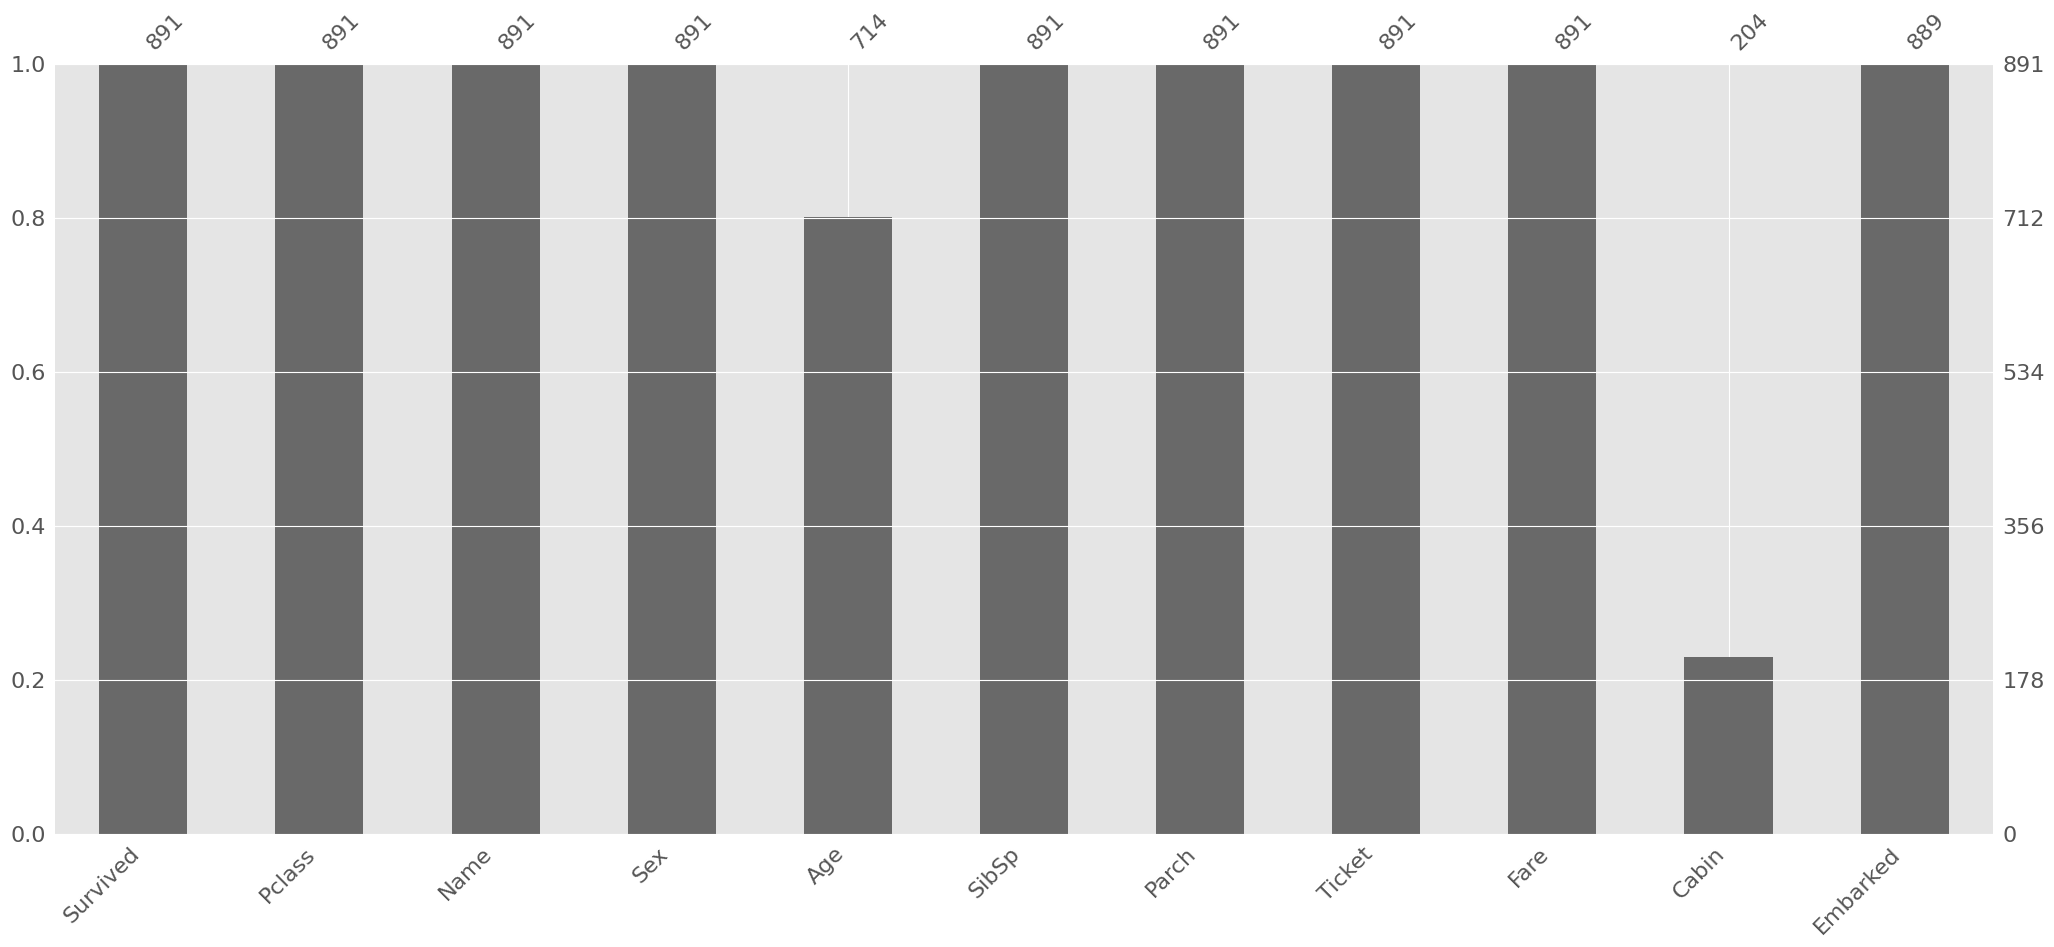

In [614]:
msno.bar(df_train)

<AxesSubplot: >

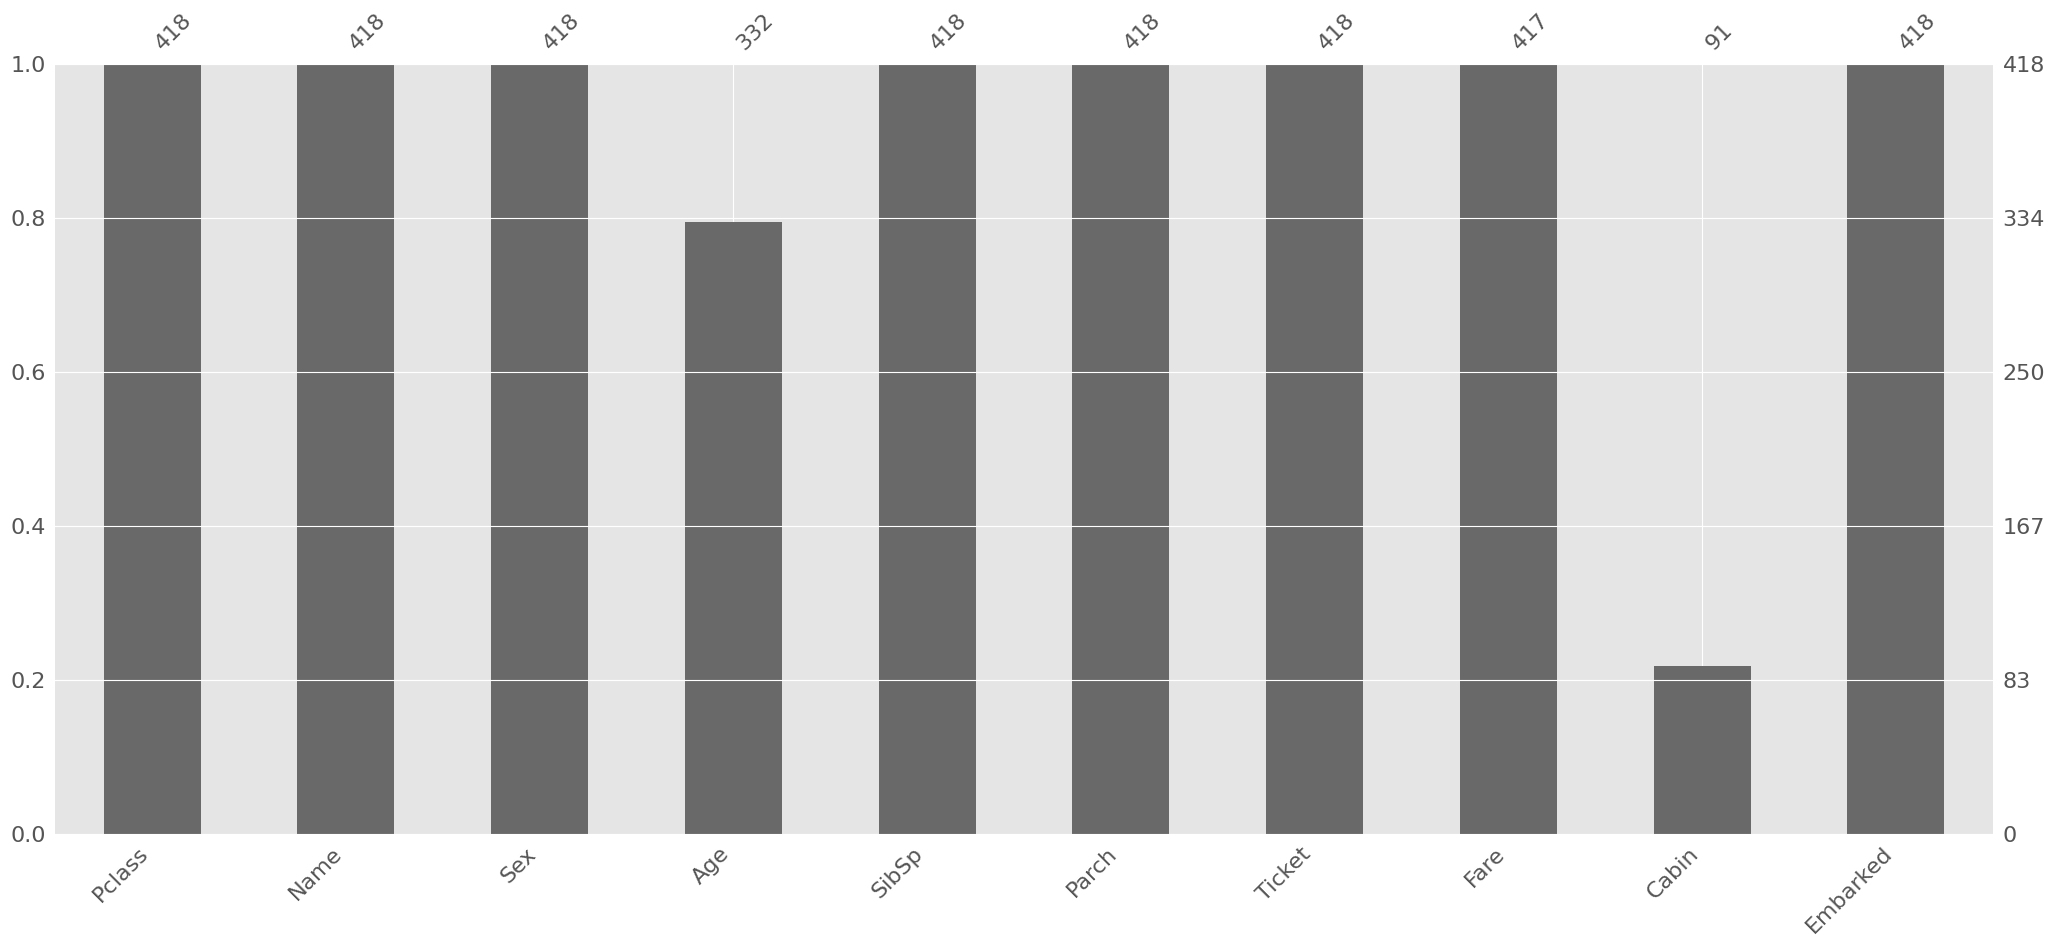

In [615]:
msno.bar(df_test)

## Plot the data

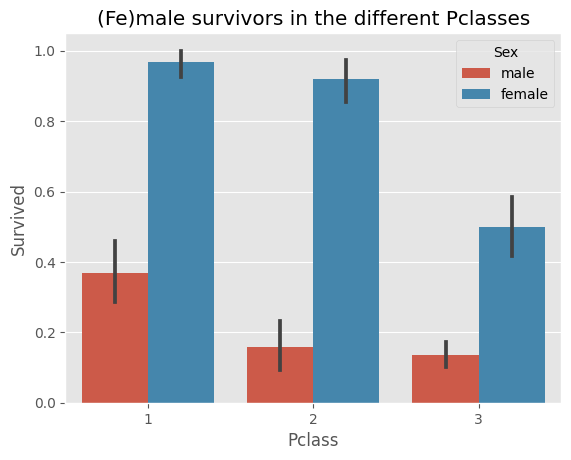

In [616]:
sns.barplot(x='Pclass',y='Survived', hue='Sex', data=df_train)
plt.title("(Fe)male survivors in the different Pclasses")
plt.show()
plt.close()

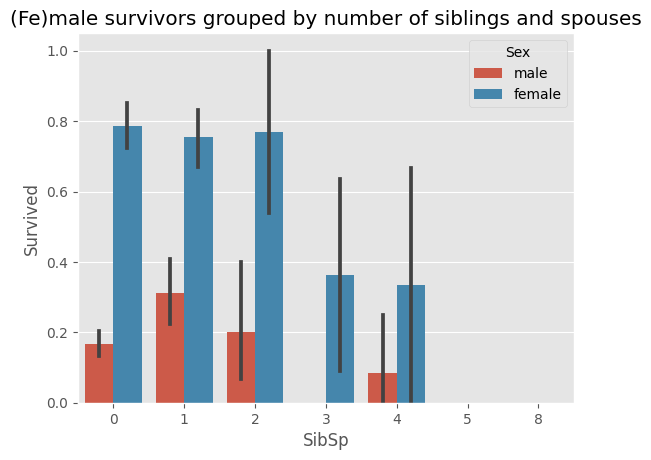

In [617]:
sns.barplot(x='SibSp',y='Survived', hue='Sex', data=df_train)
plt.title("(Fe)male survivors grouped by number of siblings and spouses")
plt.show()
plt.close()

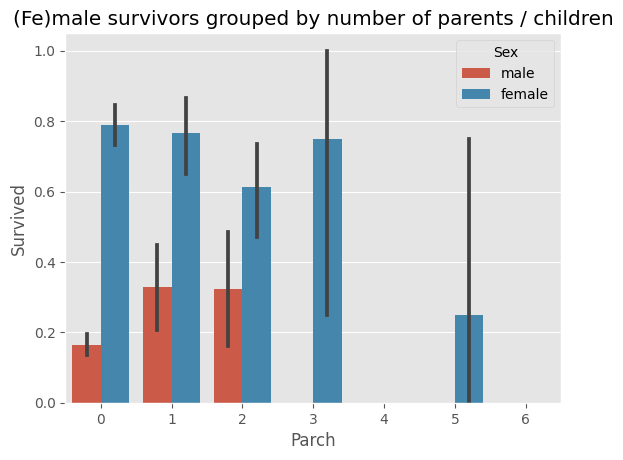

In [618]:
sns.barplot(x='Parch',y='Survived', hue='Sex', data=df_train)
plt.title("(Fe)male survivors grouped by number of parents / children")
plt.show()
plt.close()

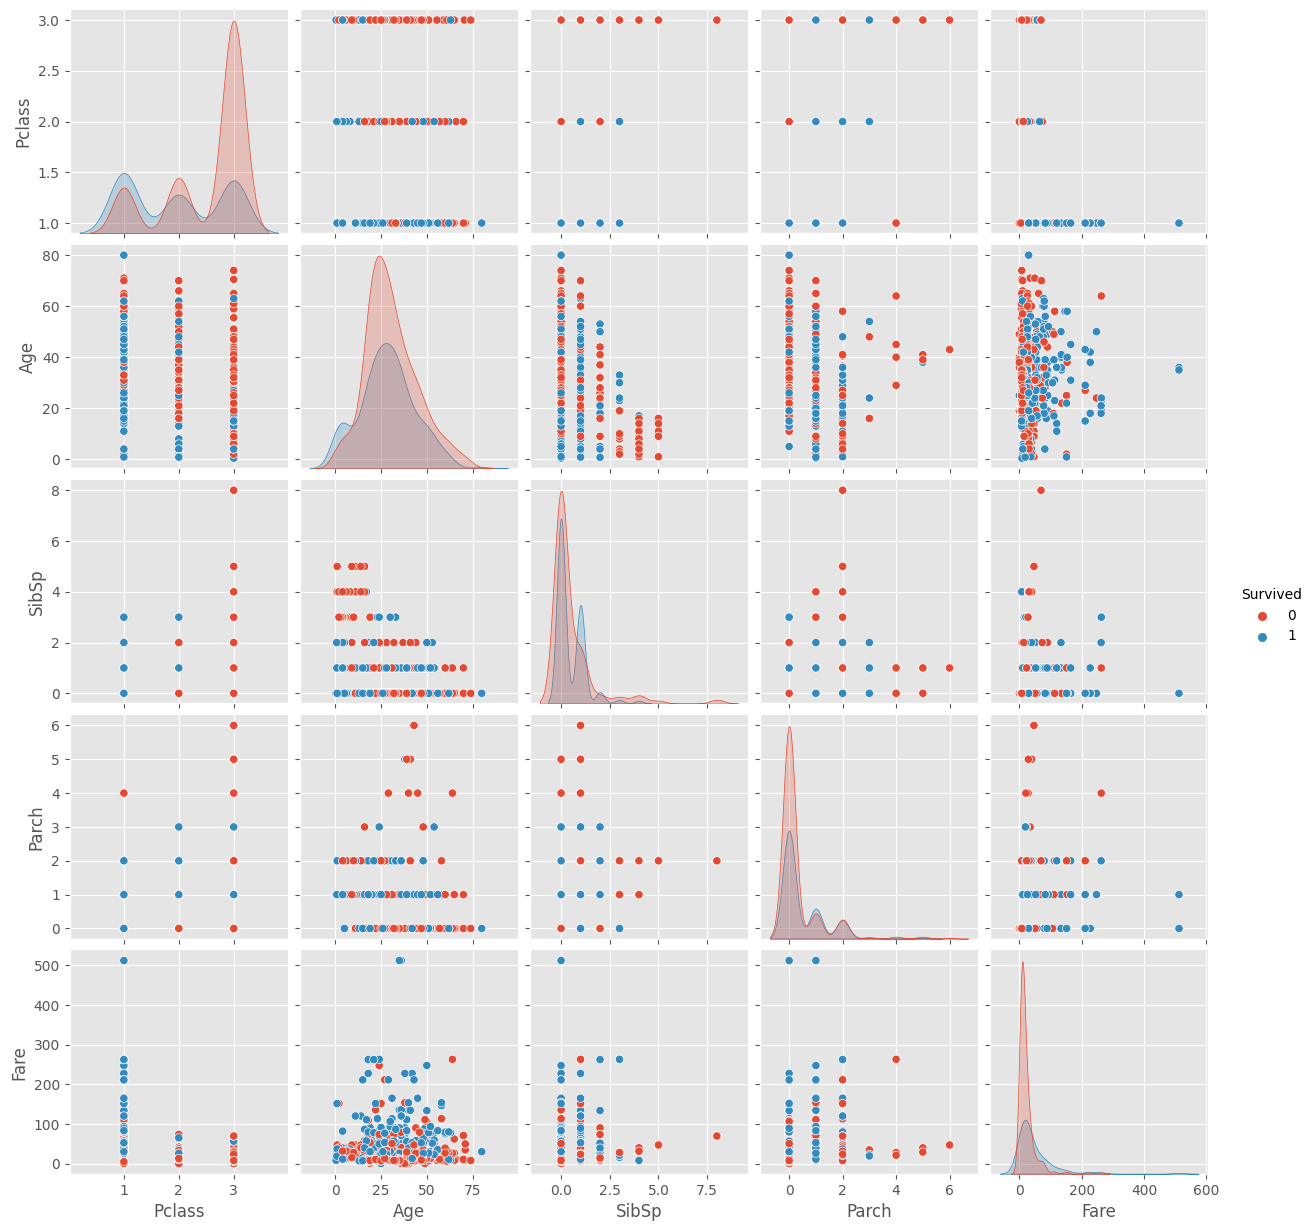

In [619]:
sns.pairplot(df_train, hue='Survived')

<AxesSubplot: >

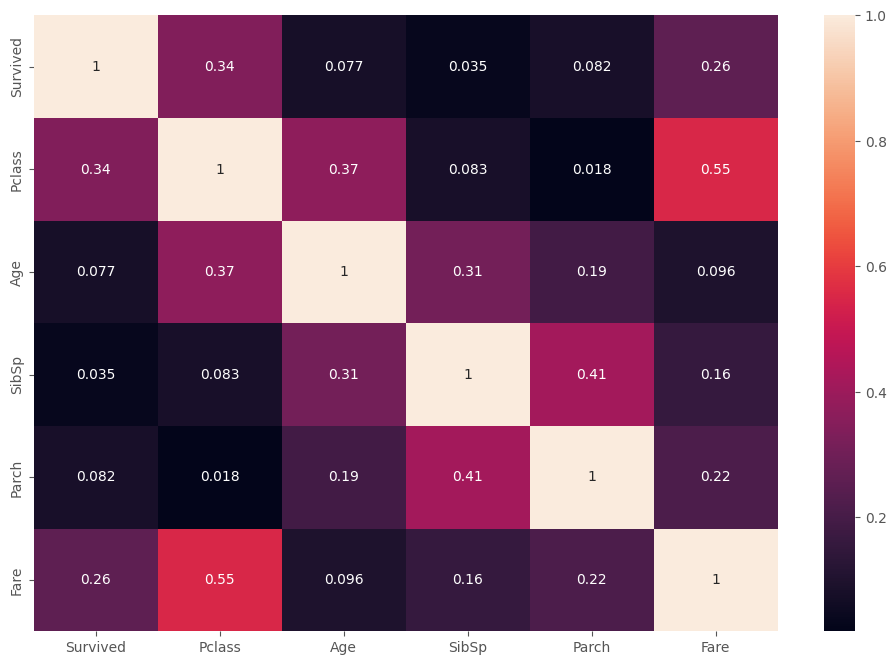

In [620]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(numeric_only = True).abs(), annot=True)

## Observations 
 * Cabin has a lot of missing values (drop it). 
 * Name column contains the title. Extract it.
 * Embarkation is the port where the passengers boarded C=Cherbourg (168), Q=Queenstown (77), S=Southampton (644), there are only two values missing. Just use "S" for the two missing values.
 * Some Age values are missing. Try the IterativeImputer (careful it is experimental). The iterative Imputer is a regression and finds the best fitting values.
 * I don't even want to know how the Ticketnumber logic is. I hope it is random and has no information. I will just drop it here.
 * In the name column only the title can be from importance. Try to extract it this feature and drop the name.
 * The test data set has one Fare value missing. 

## Feature Engineering

Combine df_train, df_test for feature engineering

In [622]:
df_combi = pd.concat([df_train, df_test], axis=0)
df_combi.shape

(1309, 11)

### Extract the title of the name column. 

Notice that the title comes always after the first comma and ends with a dot.

In [623]:
df_combi['Title'] = df_combi['Name'].str.extract('([A-Za-z]+)\.', expand=False)

<AxesSubplot: xlabel='Title', ylabel='count'>

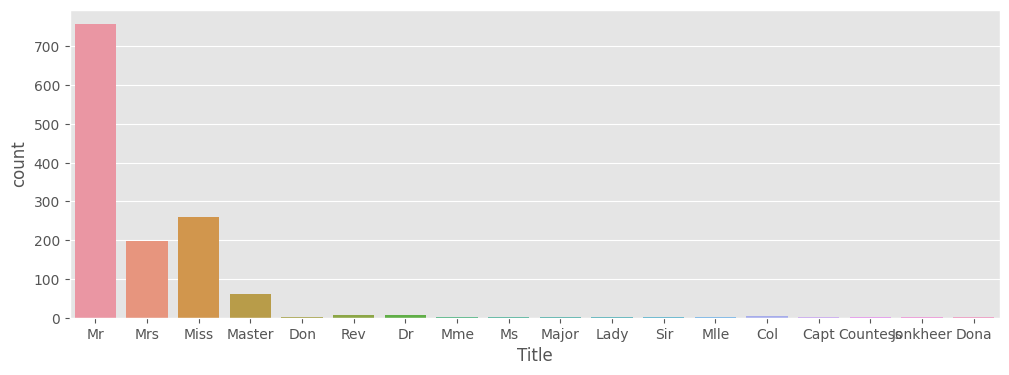

In [624]:
plt.figure(figsize=(12,4))
sns.countplot(x='Title', data=df_combi)

Most of the titles are rare. Therefore rename some of them or call them "noble". We have the following:

* Mlle = Mademoiselle is equivalent to "Miss"
* Mme = Madame is equivalent to "Mrs"
* Ms = is only one which is 28 years old. It shouldnt matter. Is now a "Mrs"

The rest will be renamed to "noble".

In [625]:
renamer = {"Miss" : "Mlle",
           "Mrs": ["Mme", "Ms"],
           "noble": ["Don","Rev","Dr","Lady","Sir","Col","Countess","Mme","Major","Capt","Jonkheer","Dona"]}

for k in renamer:
    df_combi["Title"] = df_combi["Title"].replace(renamer[k],k)

In [626]:
df_combi["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'noble'], dtype=object)

### Imputing and One-Hot-Encoding

Fill the one missing Fare value in the Test data.

In [627]:
df_combi[df_combi["Fare"].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [628]:
print(df_train["Fare"].mean())
print(df_train[df_train["Pclass"]==3]["Fare"].mean())
fare_value = df_train[df_train["Pclass"]==3]["Fare"].mean()

32.204207968574636
13.675550101832993


In [629]:
df_combi["Fare"] = df_combi["Fare"].fillna(fare_value)

In [630]:
df_combi.loc[df_combi["Embarked"].isna(), "Embarked"] = "S"

In [631]:
df_combi['Sex'] = df_combi['Sex'].map({'male': 0, 'female': 1})
df_combi = pd.get_dummies(df_combi, columns=['Embarked', 'Title'], drop_first=True)

In [632]:
df_combi.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_noble
0,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,1,0,0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,1,0
2,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,0,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,0,0,1,0
4,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,0,1,0,0


In [633]:
df_combi['FamilySize'] = df_combi['SibSp'] + df_combi['Parch']

<AxesSubplot: >

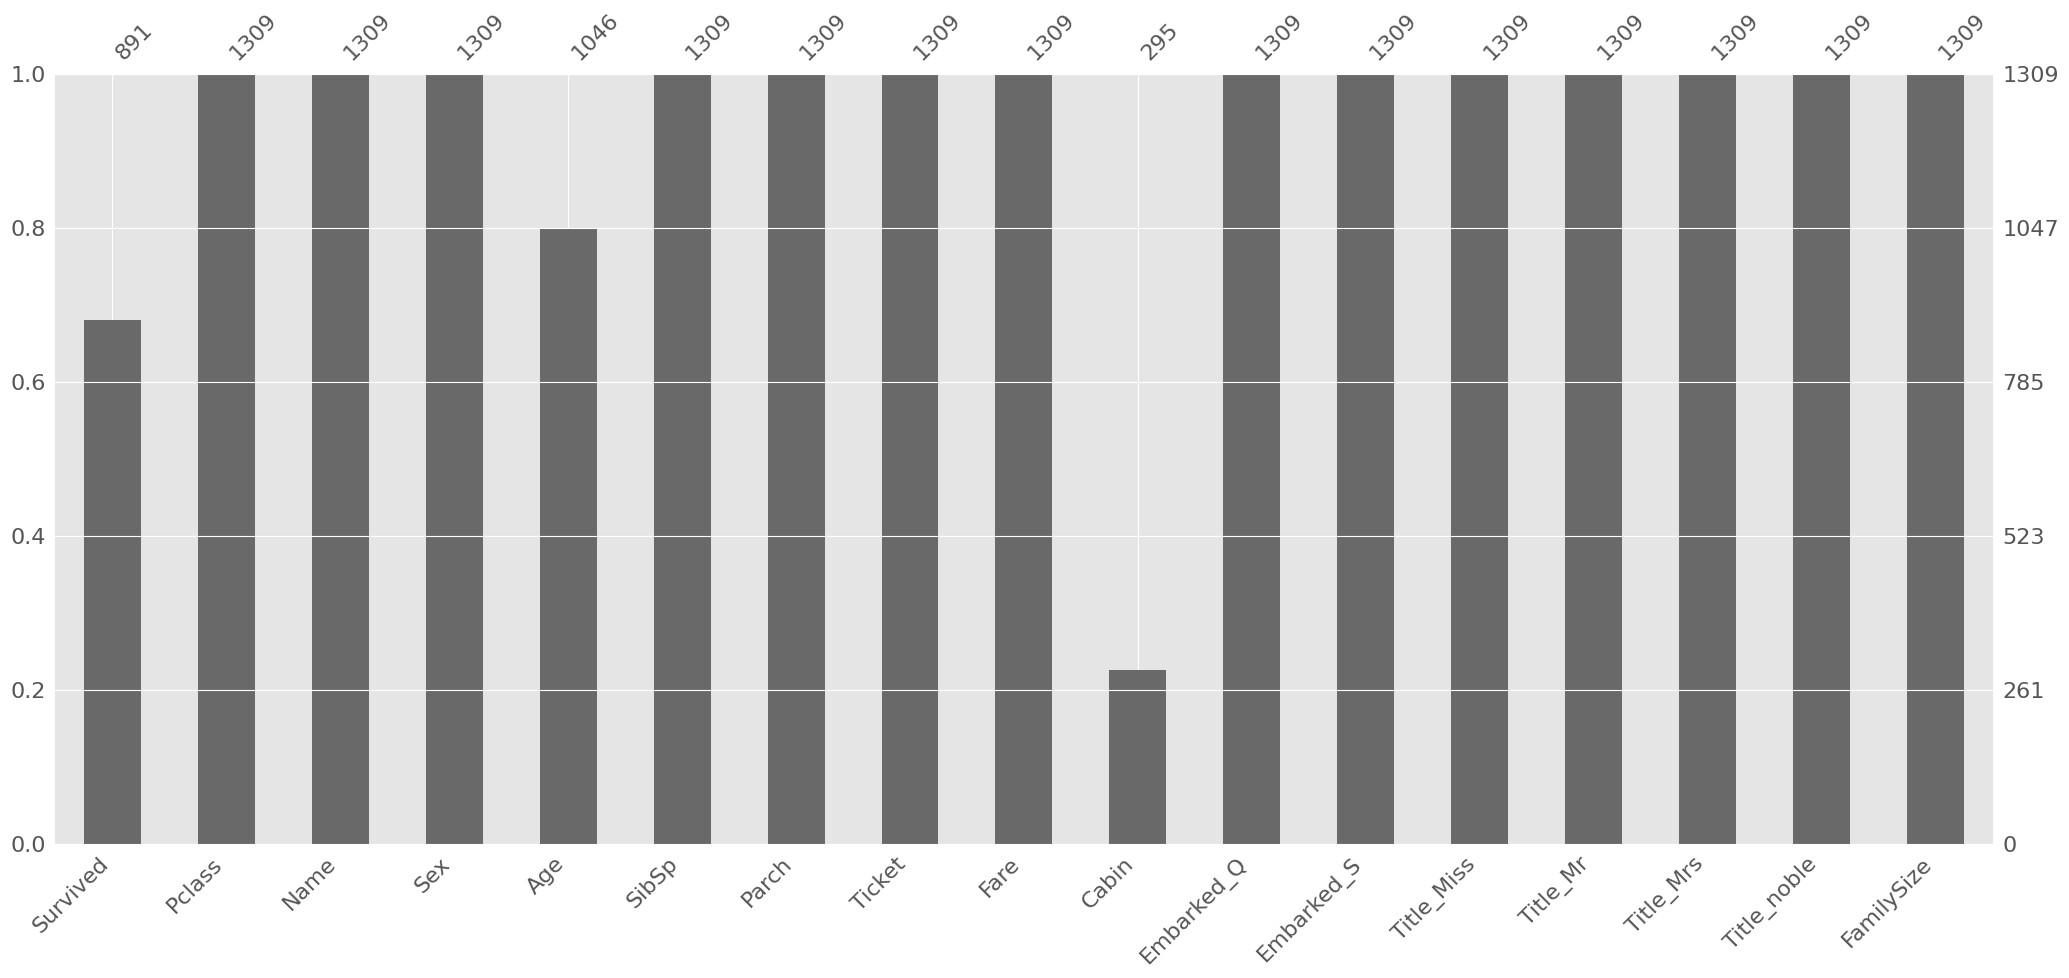

In [634]:
msno.bar(df_combi)

For Age we use the IterateImputer. For this it is only allowed to use the information from the train set and omit the information from the survived column. So split them again.

In [723]:
train_df = df_combi[:len(df_train)].drop(columns=["Name", "Ticket", "Cabin"])
test_df = df_combi[len(df_train):].drop(columns=["Name", "Ticket", "Cabin", "Survived"])

In [724]:
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[["Fare", "FamilySize"]] = scaler.fit_transform(train_df[["Fare", "FamilySize"]])
test_df[["Fare", "FamilySize"]] = scaler.transform(test_df[["Fare", "FamilySize"]])

Now impute the Age with the help of iterative Imputer.

In [725]:
df_age = train_df.drop(columns=["Survived"])

In [726]:
iter_imp = IterativeImputer()
iter_imp.fit(df_age)

IterativeImputer()

In [727]:
cols = iter_imp.get_feature_names_out()

In [728]:
train_df = pd.DataFrame(iter_imp.transform(df_age), columns = cols)
test_df  = pd.DataFrame(iter_imp.transform(test_df), columns = cols)
age = train_df[["Age"]]
age_test = test_df[["Age"]]

<AxesSubplot: >

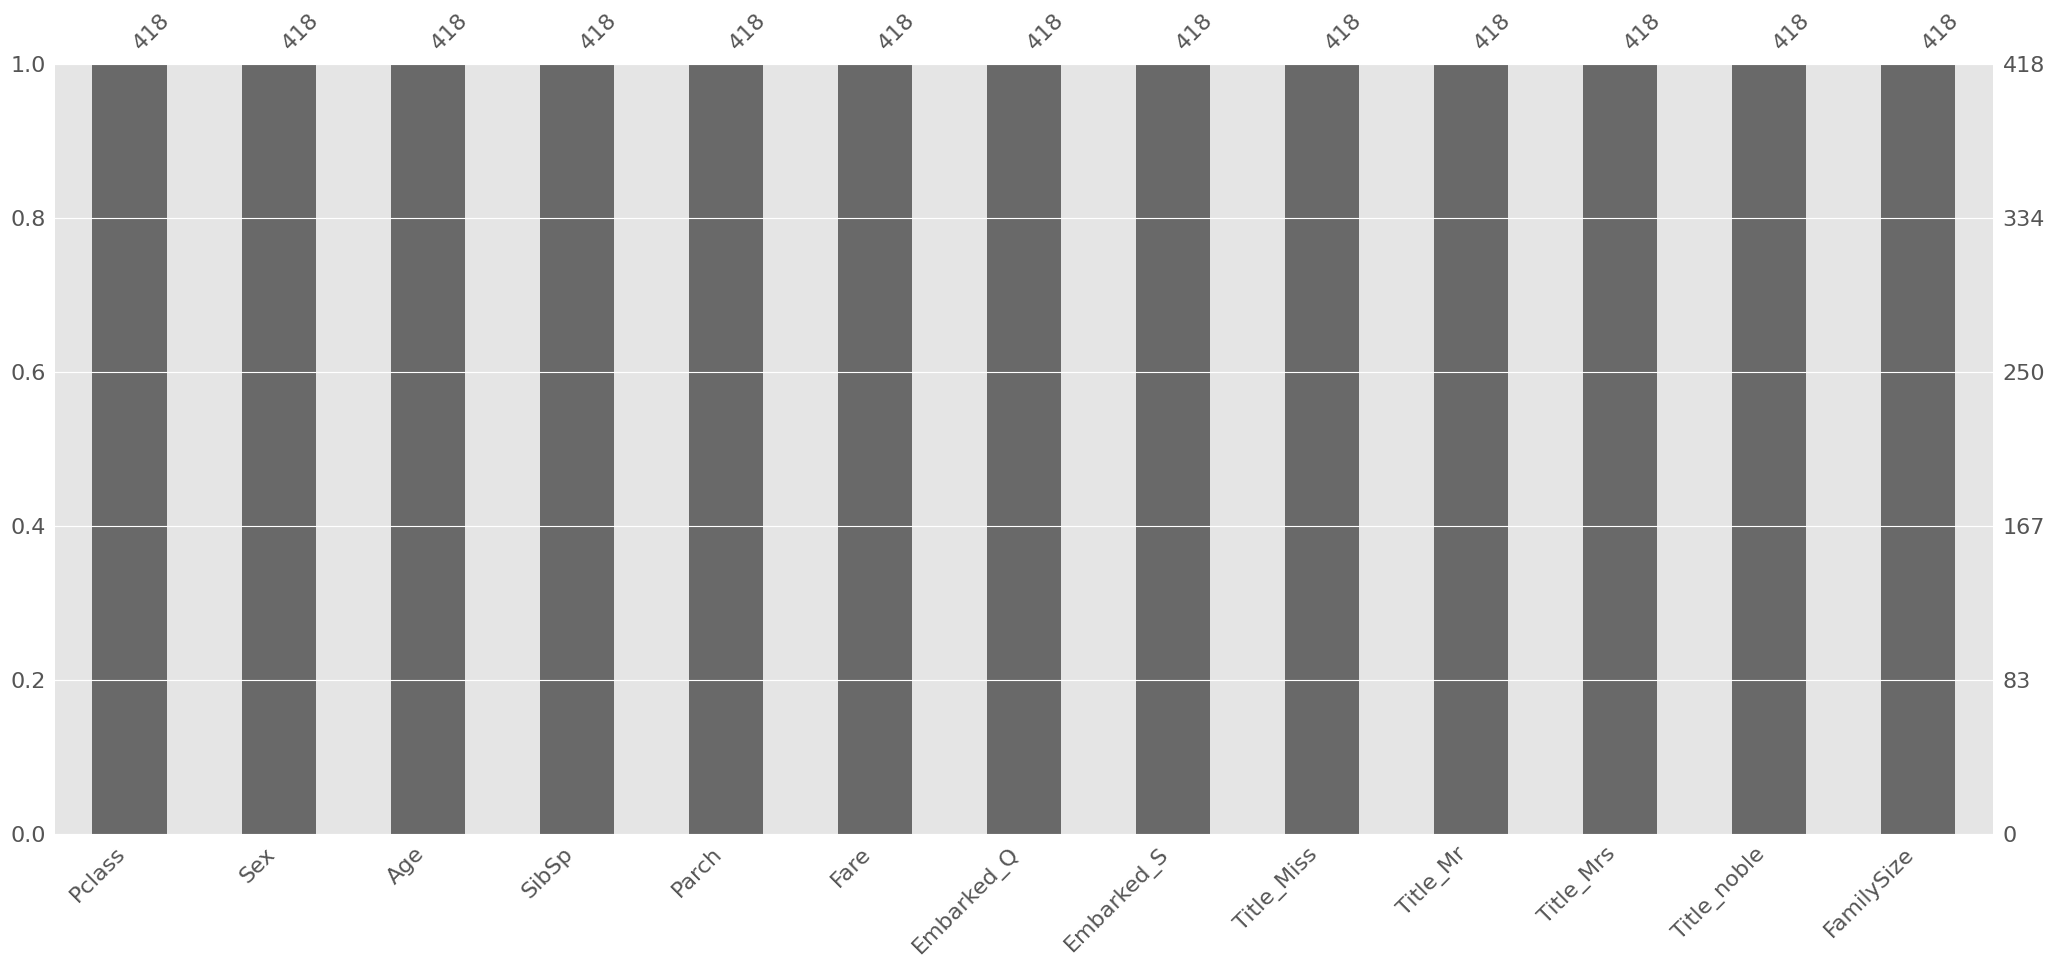

In [729]:
msno.bar(test_df)

### Scale the data

In [730]:
scaler = MinMaxScaler()
train_df[["Age"]] = scaler.fit_transform(train_df[["Age"]])
test_df[["Age"]] = scaler.transform(test_df[["Age"]])

In [731]:
train_df.dtypes

Pclass         float64
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Fare           float64
Embarked_Q     float64
Embarked_S     float64
Title_Miss     float64
Title_Mr       float64
Title_Mrs      float64
Title_noble    float64
FamilySize     float64
dtype: object

In [732]:
for col in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_noble']:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

### Binning of the data

In that time with the age of 14 and below, one was considered as a child. Introduce new feature child and new feature old (older than 60)

In [735]:
train_df["Child"] = (age<15).astype(int)
test_df["Child"] = (age_test<15).astype(int)

train_df["Elder"] = (age>59).astype(int)
test_df["Elder"] = (age_test>59).astype(int)

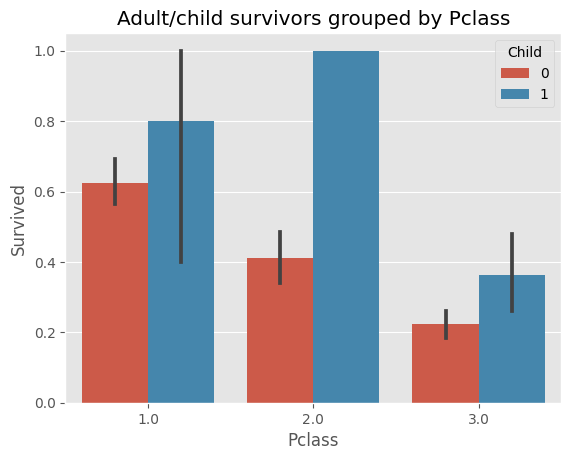

In [739]:
train_df["Survived"] = df_train["Survived"]
sns.barplot(x='Pclass',y='Survived', hue='Child', data=train_df)
plt.title('Adult/child survivors grouped by Pclass')
plt.show()
plt.close()

To be a child is a good indicator for surviving!

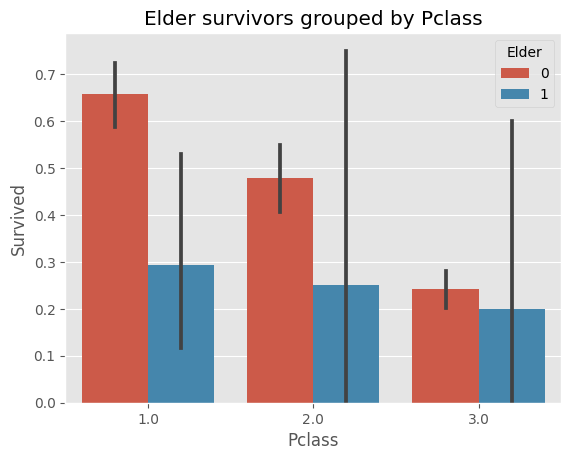

In [742]:
sns.barplot(x='Pclass',y='Survived', hue='Elder', data=train_df)
plt.title('Elder survivors grouped by Pclass')
plt.show()
plt.close()

In [743]:
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

In [746]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [767]:
pipeline = Pipeline([
    ('classifier', GradientBoostingClassifier())
])

param_grid = {
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [3, 4, 5],
    'classifier__n_estimators': [100, 200, 300]
}

In [768]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]})

In [775]:
grid_search.score(X, y)

0.9371492704826038

In [769]:
y_pred = grid_search.predict(test_df)

In [770]:
print(cross_val_score(grid_search, X, y, cv=3))

[0.81144781 0.83501684 0.83501684]


In [752]:
submission_df = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_pred})
submission_df.to_csv('submission.csv', index=False)

## Train some models

In [326]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Train["Survived"])

In [337]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(Xtrain, ytrain)
dumm_pred = dummy_clf.predict(Xtest)

In [510]:
best = SelectKBest(chi2, k=10)
X_new = best.fit_transform(Xtrain, ytrain)
Xt_new = best.transform(Xtest)

In [511]:
Xtrain.shape

(668, 26)

In [513]:
Xt_new.shape

(223, 10)

In [514]:
logreg = LogisticRegression(C=10)  #class_weight='balanced'
logreg.fit(X_new, ytrain);
print(logreg.score(X_new, ytrain))
print(logreg.score(Xt_new, ytest))

0.8233532934131736
0.8026905829596412


In [501]:
m = RFECV(xgb.XGBClassifier(), scoring="accuracy")
m.fit(Xtrain, ytrain)

RFECV(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      scoring='accuracy')

In [502]:
print(m.score(Xtrain, ytrain))

0.9745508982035929


In [503]:
print(m.score(Xtest, ytest))

0.7937219730941704


In [516]:
rf = RandomForestClassifier(n_estimators=100, max_depth=100, max_features=2, random_state=42) 
rf.fit(X_new, ytrain)
#plt.barh(X_train.columns, rf.feature_importances_)

RandomForestClassifier(max_depth=100, max_features=2, random_state=42)

In [522]:
df_train["Survived"].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Survived, Length: 891, dtype: bool

In [517]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_new, ytrain)
#plt.barh(X_train.columns, xgbc.feature_importances_);

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [518]:
svc = SVC(C=100, gamma='auto', kernel='rbf')
svc.fit(X_new, ytrain)

SVC(C=100, gamma='auto')

In [520]:
models = [dummy_clf, logreg, rf, xgbc, svc]

def print_scores(models, Xtrain, ytrain, Xtest, ytest):
    for m in models:
        print(type(m).__name__)
        print('Trainscore: ', m.score(Xtrain, ytrain))
        print('Testscore: ', m.score(Xtest, ytest))
        print()
        
print_scores(models, X_new, ytrain, Xt_new, ytest)

DummyClassifier
Trainscore:  0.625748502994012
Testscore:  0.5874439461883408

LogisticRegression
Trainscore:  0.8233532934131736
Testscore:  0.8026905829596412

RandomForestClassifier
Trainscore:  0.9476047904191617
Testscore:  0.7443946188340808

XGBClassifier
Trainscore:  0.9356287425149701
Testscore:  0.7757847533632287

SVC
Trainscore:  0.8577844311377245
Testscore:  0.7982062780269058



In [490]:
for m in models:
    cv_all = cross_val_score(m, Xtrain, ytrain, cv=10, scoring='accuracy')
    cv_mean = cv_all.mean()
    cv_std = cv_all.std()
    train_score = m.score(Xtrain, ytrain)
    print(f"Cross-validation mean {cv_mean:5.3f} +- {cv_std:5.3f}")
    # Is the score inside the range?
    print(train_score > cv_all.min() and train_score < cv_all.max())
    print(abs(train_score - cv_mean) < cv_std)

Cross-validation mean 0.626 +- 0.002
True
True
Cross-validation mean 0.835 +- 0.044
True
True
Cross-validation mean 0.800 +- 0.056
False
False
Cross-validation mean 0.822 +- 0.051
False
False
Cross-validation mean 0.846 +- 0.036
True
True


In [418]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2', 'elasticnet', None],
              'class_weight':['balanced',None]}

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,n_jobs=-1, cv=5) 

# fitting the model for grid search 
grid.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(Xtest) 

# print classification report 
print(classification_report(ytest, grid_predictions)) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 10, 'class_weight': None, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       131
           1       0.82      0.66      0.73        92

    accuracy                           0.80       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.81      0.80      0.80       223



/Users/palex/miniforge3/envs/logreg/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/palex/miniforge3/envs/logreg/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

In [425]:
# defining parameter range 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 50, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1) 

# fitting the model for grid search 
grid.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(Xtest) 

# print classification report 
print(classification_report(ytest, grid_predictions)) 

Fitting 5 folds for each of 162 candidates, totalling 810 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       131
           1       0.84      0.66      0.74        92

    accuracy                           0.81       223
   macro avg       0.81      0.79      0.79       223
weighted avg       0.81      0.81      0.80       223



In [419]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1, cv=5) 

# fitting the model for grid search 
grid.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(Xtest) 

# print classification report 
print(classification_report(ytest, grid_predictions)) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       131
           1       0.88      0.58      0.70        92

    accuracy                           0.79       223
   macro avg       0.82      0.76      0.77       223
weighted avg       0.81      0.79      0.78       223



## Calculate Test score

In [363]:
def print_score(X, y, models):
    if type(models)!=list:
        models = [models]
    for m in models:
        y_pred = m.predict(X)
        print('\033[1m' + 'The Score for the model: ' + '\033[0m', type(m).__name__ , '\n')
        print('accuracy: ', accuracy_score(y, y_pred))
        print(classification_report(y, y_pred, target_names=['Died', 'Survived'], zero_division=1))

        cm = confusion_matrix(y, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()
        plt.close()

The Score for the model:  DummyClassifier 

accuracy:  0.5874439461883408
              precision    recall  f1-score   support

        Died       0.59      1.00      0.74       131
    Survived       1.00      0.00      0.00        92

    accuracy                           0.59       223
   macro avg       0.79      0.50      0.37       223
weighted avg       0.76      0.59      0.43       223



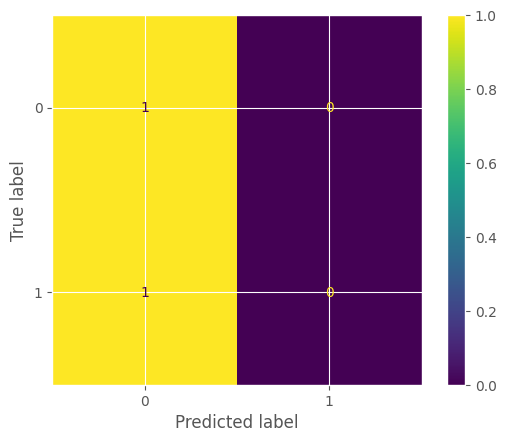

The Score for the model:  LogisticRegression 

accuracy:  0.8026905829596412
              precision    recall  f1-score   support

        Died       0.82      0.85      0.83       131
    Survived       0.77      0.74      0.76        92

    accuracy                           0.80       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.80      0.80      0.80       223



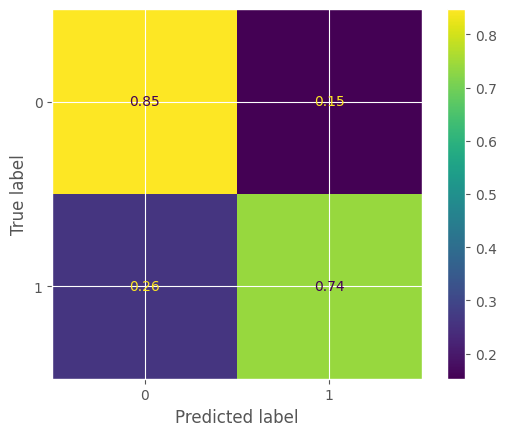

The Score for the model:  RandomForestClassifier 

accuracy:  0.7892376681614349
              precision    recall  f1-score   support

        Died       0.77      0.91      0.84       131
    Survived       0.83      0.62      0.71        92

    accuracy                           0.79       223
   macro avg       0.80      0.76      0.77       223
weighted avg       0.79      0.79      0.78       223



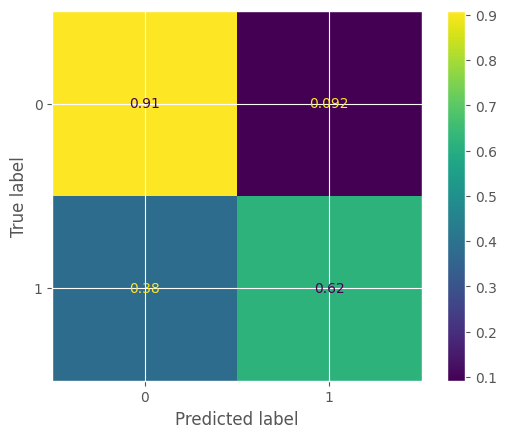

The Score for the model:  XGBClassifier 

accuracy:  0.7937219730941704
              precision    recall  f1-score   support

        Died       0.78      0.90      0.84       131
    Survived       0.82      0.64      0.72        92

    accuracy                           0.79       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.79      0.79       223



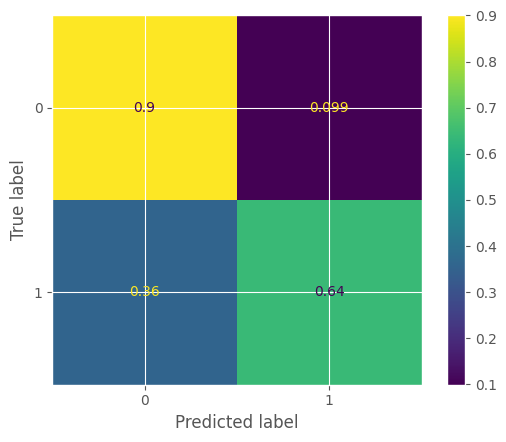

In [369]:
models = [dummy_clf, logreg, rf, xgbc]

print_score(Xtest, ytest, models)

In [370]:
def plot_roc_pr_curve(X, y, models):
    """
        PARAMETERS:
        
        X   :   Dataframe X
        y   :   Target values
        m   :   list of models
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    if type(models)!=list:
        models = [models]
    
    fig, (ax, bx) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=100)
    ax.set_aspect(1)
    bx.set_aspect(1)
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    text = "AUC: \n"
    
    for m in models:
        name = type(m).__name__
        y_proba = m.predict_proba(X)[:, 1]

        # calculate metrics
        auc = roc_auc_score(y, y_proba)
        fpr, tpr, roc_thr = roc_curve(y, y_proba)
        precision, recall, pr_thr = precision_recall_curve(y, y_proba)
        
        text +=  name + ": " + str(np.round(auc, 3)) + "\n"
        
        a_id = find_nearest(roc_thr, 0.5)
        b_id = find_nearest(pr_thr, 0.5)

        ta_x, ta_y = (fpr[a_id], tpr[a_id])
        tb_x, tb_y = (precision[b_id], recall[b_id])

        ### ROC Curve
        ax.plot(fpr, tpr, marker=".", label=name)
        bx.plot(recall, precision, marker='.')
    
    ax.text(0.65, 0.1, text[:-1], ha="center", va="center", size=13, bbox=bbox_props)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title("ROC Curve")
    bx.set_title("Precision-Recall Curve")
    bx.set_xlabel('Recall')
    bx.set_ylabel('Precision')
    fig.legend()

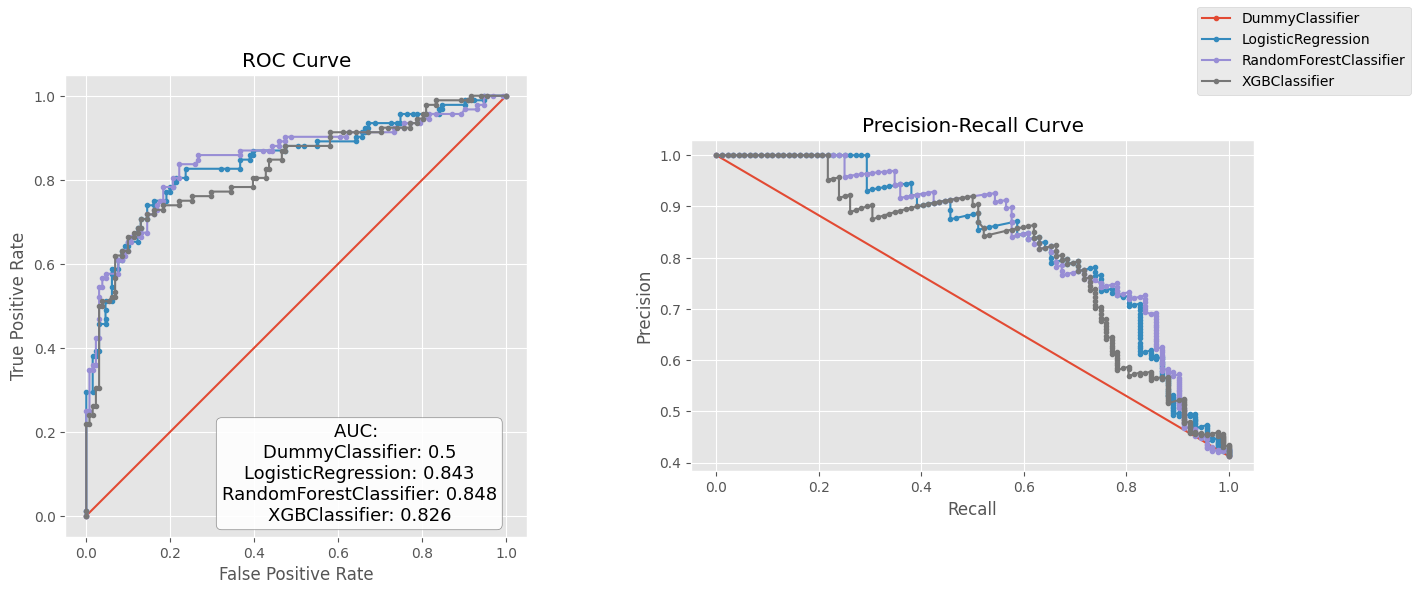

In [371]:
plot_roc_pr_curve(Xtest, ytest, models)

# Kaggle submission

In [435]:
X_train.head()

,Age,Fare,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_noble,Sex_1,SibSp_1,...,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_Q,Embarked_S,Child,Elder
0,0.271174,0.014151,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
1,0.472229,0.139136,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0.321438,0.015469,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,0.434531,0.103644,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4,0.434531,0.015713,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


### Try with training on full train data set.

In [436]:
y = Train["Survived"]

In [464]:
logreg_full = LogisticRegression(C=10, max_iter=1000)
logreg_full.fit(X_train, y)
logreg_full.score(X_train, y)

0.8249158249158249

In [443]:
svc_full = SVC(C=100)
svc_full.fit(X_train, y)
svc_full.score(X_train, y)

0.8664421997755332

In [444]:
rf_full = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_full.fit(X_train, y)
rf_full.score(X_train, y)

0.8439955106621774

In [451]:
xgbc_full = xgb.XGBClassifier()
xgbc_full.fit(X_train, y)
xgbc_full.score(X_train, y)

0.9741863075196409

In [467]:
from sklearn.ensemble import StackingClassifier

In [478]:
estimators = [('logreg', LogisticRegression(C=10, max_iter=1000)),
              ('svc', SVC(C=100)),
              ('rf', RandomForestClassifier(**{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100})),
              ('xgb', xgb.XGBClassifier())]

name, model = "ensemble", StackingClassifier(estimators=estimators,
                final_estimator=LogisticRegression(**{"penalty":"l2","solver": "liblinear","C":0.2,}),)

In [479]:
model.fit(X_train, y)
model.score(X_train,y)

0.9068462401795735

In [480]:
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
output.to_csv('submission_full.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
